ABR test for orginial data with any sampling or add noise

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import itertools, operator, random, math
from scipy.sparse.linalg import spsolve_triangular
from sklearn import linear_model
import utils as ut
import pandas as pd
%matplotlib inline

In [59]:
def abr(t, pop, popt):
    la, lb, lr, ra, rb, rr = pop
    ka, da, dab = 400, 2, 400
    kb, kbb, db, dba = 2, 30, 2.8, 30
    kr, krb, dr = 0.1, 1.5, 0.2
    at, bt, rt = popt

    dladt = ka*(at-la-ra)*lr - da*la - dab*la*lb**2
    dlbdt = (bt-lb-rb)*(kb + kbb*lb) - db*lb - dba*la*lb**2
    dlrdt = (rt-lr-rr)*(kr+krb*lb) - dr*lr
    dradt = ka*(at-la-ra)*rr - da*ra - dab*ra*rb**2
    drbdt = (bt-lb-rb)*(kb + kbb*rb) - db*rb - dba*ra*rb**2
    drrdt = (rt-lr-rr)*(kr+krb*rb) - dr*rr
    dpop = np.array([dladt, dlbdt, dlrdt, dradt, drbdt, drrdt])
    return dpop

In [74]:
popt1 = [1, 1, 1]
dt, pts = 0.01, int(60/0.01)
tspan = np.linspace(dt, 60, num=pts)
pop0 = [1, 0, 0, 0, 1, 1]
##
sol1 = integrate.solve_ivp(fun =lambda t,x :abr(t,x,popt1), t_span=[tspan[0], tspan[-1]], y0=pop0, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
pop1 = sol1.y[:,100:-100]
dpop1 = abr(sol1.t, sol1.y, popt1)
##
popt2 = [0.5, 1, 1]
sol2 = integrate.solve_ivp(fun =lambda t,x :abr(t,x,popt2), t_span=[tspan[0], tspan[-1]], y0=pop0, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dpop2 = abr(sol2.t, sol2.y, popt2)
##
popt3 = [1, 0.5, 1]
sol3 = integrate.solve_ivp(fun =lambda t,x :abr(t,x,popt3), t_span=[tspan[0], tspan[-1]], y0=pop0, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dpop3 = abr(sol3.t, sol3.y, popt3)


In [121]:
pop_data = np.hstack([sol1.y[:,100:-100], sol2.y[:,100:-100], sol3.y[:,100:-100]])
dpop_data = np.hstack([dpop1[:,100:-100], dpop2[:,100:-100], dpop3[:,100:-100]])

In [122]:
dpop_diff = ut.time_different(dt, dpop_data, pop_data)

In [ ]:
theta

In [158]:
 label = ['la', 'lb', 'lr', 'ra', 'rb','rr']
 theta, descr = ut.lib_terms(pop_data,3,label)
#  Xi_std = ut.sparsifyDynamics(theta, dpop_diff.T, 0.001)
 clf = linear_model.Lasso(alpha=0.0002, fit_intercept=False, max_iter=1e4)
 clf.fit(theta, dpop_diff.T)
 Xi_std = clf.coef_
    # clf.fit(theta_dic[term],dpop[i].T)
    # Xi_curr = clf.coef_

In [159]:
Xi_std[1]

array([ 0.        ,  0.        ,  0.26915322, -0.        , -0.        ,
       -0.19671446,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  4.49088284, -0.19398983,  0.        ,  0.        ,
       -0.        , -0.20515421,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -4.27534864,  0.22208374,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.05468454,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.12110299, -0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        , -0.09670257,
       -0.        ,  0.        , -0.        , -0.        ,  0.  

In [169]:
# df_term = ut.visual_param(Xi_std, descr)
# df_term[df_term['lr'] != 0]['lr']

1         0.013365
rb       -0.051606
ra        0.018308
lb        0.054409
lrlr     -0.144555
lblb      0.016062
lalr     -0.003941
rrrrrr   -0.022988
lblbrr    0.054604
Name: lr, dtype: float64

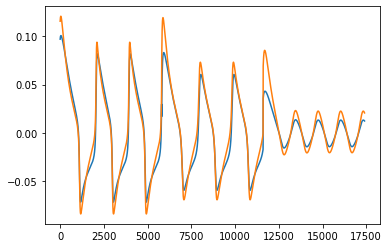

In [163]:
plt.plot(theta.dot(Xi_std.T)[:,2])
plt.plot(dpop_data[2])

In [170]:
dic = {}
dic['la'], dic['ra'] = ['1','rb', 'rr'], ['1','lb','lr']
dic['lb'], dic['rb'] = ['1','ra', 'rr'], ['1','la', 'lr']
dic['lr'], dic['rr'] = ['1','ra', 'rb'], ['1','la', 'lb']
df_prior, remain_index = ut.bulid_prior(label, theta, descr, dic)

In [171]:
df_prior

,la,lb,lr,ra,rb,rr
1,0.0,0.0,0.0,0.0,0.0,0.0
rr,0.0,0.0,1.0,1.0,1.0,1.0
rb,0.0,1.0,0.0,1.0,1.0,1.0
ra,1.0,0.0,0.0,1.0,1.0,1.0
lr,1.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...
lalarb,0.0,1.0,0.0,1.0,0.0,0.0
lalara,1.0,0.0,0.0,1.0,0.0,0.0
lalalr,1.0,1.0,1.0,0.0,0.0,0.0
lalalb,1.0,1.0,1.0,0.0,0.0,0.0


In [195]:
theta_dic = {}
for i, term in enumerate(label):
    theta_dic[term] = theta[:, remain_index[i]]
    clf = linear_model.Lasso(alpha=0.0001, fit_intercept=False, max_iter=1e5)
    clf.fit(theta_dic[term],dpop_diff[i].T)
    Xi_curr = clf.coef_
    # Xi_curr = ut.sparsifyDynamics(theta_dic[term], np.expand_dims(dpop_diff[i].T,1), 0.001)
    # print(Xi_curr.shape)
    df_prior[term].iloc[remain_index[i]] = Xi_curr.T[0]

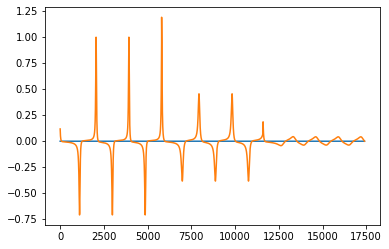

In [196]:
plt.plot(theta.dot(df_prior['lb']))
plt.plot(dpop_data[1])

In [192]:
df_prior

,la,lb,lr,ra,rb,rr
1,0.000000,0.0,0.00000,0.00000,0.000000,0.0
rr,0.000000,0.0,0.03255,0.06053,-0.960195,-0.0
rb,0.000000,0.0,0.00000,0.06053,-0.960195,-0.0
ra,-0.030998,0.0,0.00000,0.06053,-0.960195,-0.0
lr,-0.030998,0.0,0.03255,0.00000,0.000000,-0.0
...,...,...,...,...,...,...
lalarb,0.000000,0.0,0.00000,0.06053,0.000000,0.0
lalara,-0.030998,0.0,0.00000,0.06053,0.000000,0.0
lalalr,-0.030998,0.0,0.03255,0.00000,0.000000,0.0
lalalb,-0.030998,0.0,0.03255,0.00000,0.000000,0.0


In [39]:
dpop_diff = ut.time_different(dt, dpop, sol.y)

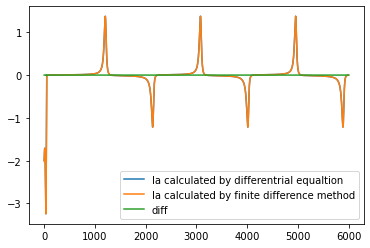

In [70]:
plt.plot(dpop[0], label='la calculated by differentrial equaltion')
plt.plot(dpop_diff[0], label= 'la calculated by finite difference method')
plt.plot(dpop_diff[0] - dpop[0], label='diff')
plt.legend()

In [32]:
theta_dic['la'].shape

(6000, 30)

In [52]:
# linear regression applied
clf = linear_model.Lasso(alpha=1e-5, fit_intercept=False, max_iter=1e5)
clf.fit(theta_dic['la'],dpop_diff[0].T)
Xi = clf.coef_

In [14]:
sol_res = integrate.solve_ivp(ut.sparseGalerkin, [tspan[0], tspan[-1]], pop0, method='RK45', atol=1e-10, rtol=1e-10, t_eval=tspan,args=(df_prior,3))

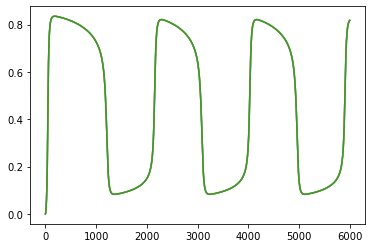

In [20]:
plt.plot(sol_res.y[1])
plt.plot(sol.y[1])
plt.plot(sol_res.y[1])

In [17]:
df_prior[df_prior['la'] !=0]['la']

ra        -752.367083
lr           2.967300
lb         966.076402
la          25.405327
rara      1416.147844
lrlr       -29.752536
lbra     -1748.914498
lblr        11.537814
lblb       -18.723555
lara      1335.323513
lalr       116.702013
lalb     -1870.898969
lala       -43.030907
rarara    -539.201156
lrlrlr      -0.323584
lbrara     309.430358
lblrlr      35.191427
lblbra     604.469414
lblblr     -16.734270
lblblb    -237.752399
larara   -1094.869491
lalrlr      28.056838
lalbra    1396.577803
lalblr     -54.246749
lalblb     -34.087358
lalara    -608.598137
lalalr    -115.883671
lalalb     908.386338
lalala      15.624450
Name: la, dtype: float64

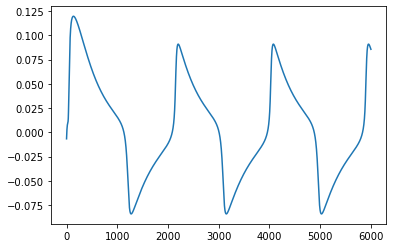

In [111]:
plt.plot(theta.dot(df_prior)[0])

In [117]:
 label = ['la', 'lb', 'lr', 'ra']
 theta_la, descr_la = ut.lib_terms(sol.y,3,label)

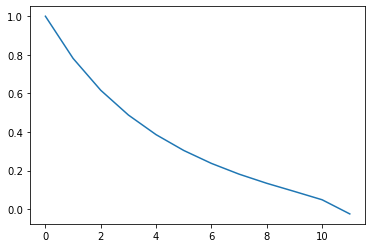

In [89]:
plt.plot(sol_res.y[0])

In [94]:
Xi_new = Xi/ theta_norm

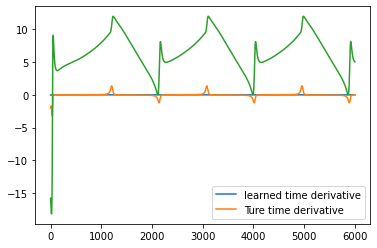

In [95]:
plt.plot(theta_new.dot(Xi_new.T)[:,0], label="learned time derivative")
plt.plot(dpop[0], label="Ture time derivative")
plt.plot(theta.dot(Xi.T)[:,0] - dpop[0])
plt.legend()

In [97]:
sol_std = integrate.solve_ivp(ut.sparseGalerkin, [tspan[0], tspan[-1]], pop0, method='RK45',atol=1e-10, rtol=1e-10, t_eval=tspan,args=(Xi_std,3))
sol_res = integrate.solve_ivp(ut.sparseGalerkin, [tspan[0], tspan[-1]], pop0, method='RK45', atol=1e-10, rtol=1e-10, t_eval=tspan,args=(Xi_new.T,3))

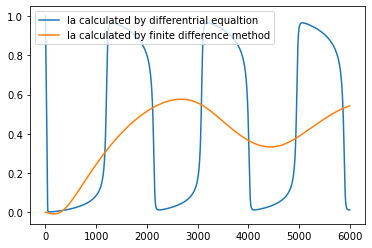

In [101]:
plt.plot(sol_std.y[0], label='la calculated by differentrial equaltion')
plt.plot(sol_res.y[2],label ='la calculated by finite difference method')
plt.legend()

In [70]:
for i in range(6):
    idx, = np.where(abs(Xi[i]) > 1e-3)
    for k in idx:
        print(descr[k+1])
    print(i)

0, 1, 0) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(0, 1, 1, 1, 0, 0) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(0, 1, 2, 0, 0, 0) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(0, 2, 0, 0, 0, 1) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(0, 2, 0, 0, 1, 0) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(0, 2, 0, 1, 0, 0) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(0, 2, 1, 0, 0, 0) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(0, 3, 0, 0, 0, 0) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(1, 0, 0, 0, 0, 2) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(1, 0, 0, 0, 1, 1) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(1, 0, 0, 0, 2, 0) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(1, 0, 0, 1, 0, 1) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(1, 0, 0, 1, 1, 0) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(1, 0, 0, 2, 0, 0) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(1, 0, 1, 0, 0, 1) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(1, 0, 1, 0, 1, 0) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(1, 0, 1, 1, 0, 0) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(1, 0, 2, 0, 0, 0) ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
(1

dla: rr, lr, rb^2, lr^2, rb*rr^2, ra^2*rr, lr*ra^2, lb^3, la*ra*rr, la*ra^2, la^2*rr, la^2*lr, la^3


dla True system: lr, la*lr, ra*lr, la, la*lb^2


dlb: ra, lb, rb^2, ra^2, lr^2, lb^2, lr*rb^2, lb^2*rb, la*lb^2, la*lb*lr


dlb True system: lb, rb, lb^2, lb*rb, la*lb^2


dlr: ra, lr, lb, lr^2, lb*rr, la^3


dlr True system: lr, rr, lb*lr, lb*rr

In [102]:
import pandas as pd
def visual_param(Xi, descr):
    small_idx = abs(Xi) < 1e-4
    Xi[small_idx] = 0
    new_set =  [x.replace('(', '').replace(']', '') for x in descr] 
    name_s = ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
    label = []
    for str_ in new_set[2:]:
        idx_ = [int(x) for x in str_.split(') [')[0].split(',')]
        lab = ""
        for idx, i in enumerate(idx_):
            j = i
            while j > 0:
                lab += name_s[idx]
                j -= 1
        label.append(lab)

    term_label = ['1'] + label

    df_term = pd.DataFrame(Xi.T, index=term_label, columns=name_s)

    return df_term
df_term = visual_param(Xi_new, descr)

In [104]:
df_term.sort_values(by=['la'])['la'][:5], df_term.sort_values(by=['la'])['la'][-5:]

(larara   -0.357012
 lara     -0.294775
 lalbrr   -0.257251
 rarb     -0.222214
 lararr   -0.212833
 Name: la, dtype: float64,
 rarrrr    0.192447
 lalara    0.205762
 rara      0.231721
 lararb    0.325905
 lalrra    0.341565
 Name: la, dtype: float64)

In [144]:
def power_(d,order):
# d is the number of variables; order of polynomials
    powers = []
    for p in range(1,order+1):
        size = d + p - 1
        for indices in itertools.combinations(range(size), d-1):   ##combinations
            starts = [0] + [index+1 for index in indices]
            stops = indices + (size,)
            powers.append(tuple(map(operator.sub, stops, starts)))
    return powers
def lib_terms(data,order,description):
    #description is a list of name of variables, like [R, M, S]
    #description of lib
    descr = []
    #data is the input data, like R,M,S; order is the total order of polynomials

    d,t = data.shape # d is the number of variables; t is the number of time points
    theta = np.ones((t,1), dtype=np.float64) # the first column of lib is '1'
    P = power_(d,order)
    descr = ["1"]
    for i in range(len(P)):
        new_col = np.zeros((t,1),dtype=np.float64)
        for j in range(t):
            new_col[j] = np.prod(np.power(list(data[:,j]),list(P[i])))
        theta = np.hstack([theta, new_col.reshape(t,1)])
        descr.append("{0} {1}".format(str(P[i]), str(description)))
        # print((str(P[i]), str(description)))
    

    return theta, descr

In [185]:
data, order, description  = x.T,2, ['la', 'lb']

descr = []
#data is the input data, like R,M,S; order is the total order of polynomials

d,t = data.shape # d is the number of variables; t is the number of time points
theta = np.ones((t,1), dtype=np.float64) # the first column of lib is '1'
P = power_(d,order)
descr = ["1"]
for i in range(len(P)):
    new_col = np.zeros((t,1),dtype=np.float64)
    output, = np.where(np.array(P[i]) > 0)
    sp = description[output[0]]
    idx = 
    
    for j in range(t):
        
        new_col[j] = np.prod(np.power(list(data[:,j]),list(P[i])))
    theta = np.hstack([theta, new_col.reshape(t,1)])
    descr.append("{0} {1}".format(str(P[i]), str(description)))

1
lb
(0, 1)
0
la
(1, 0)
1
lb
(0, 2)
0
la
(1, 1)
0
la
(2, 0)


In [178]:
theta, d = ut.lib_terms(x.T,2,['la','lb'])

In [190]:
dic = {}
dic['la'] = ['rb', 'rr']
dic['lb'] = ['ra', 'rr']
dic['lr'] = ['ra', 'rb']

In [189]:
idx_, term_ = df_term.index, df_term.columns

In [217]:
term_[]

Index(['la', 'lb', 'lr', 'ra', 'rb', 'rr'], dtype='object')

In [232]:
df_prior = pd.DataFrame(np.empty(df_term.shape))
for term in ['la']: # la
    idx_prev = idx_ # [1, 'la', 'lb']
    for s in dic[term]:
        lst_idx = [p.find(s) for p in idx_prev]
        print(lst_idx)
        x, = np.where(np.array(lst_idx) == -1)
        print(x)
        df[term] = np.ones(1, 84)

[-1, -1, 0, -1, -1, -1, -1, -1, 0, 0, -1, 2, -1, -1, 2, -1, -1, -1, 2, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, 0, 0, 0, -1, 2, 2, -1, 4, -1, -1, 2, 2, -1, 4, -1, -1, 4, -1, -1, -1, 2, 2, -1, 4, -1, -1, 4, -1, -1, -1, 4, -1, -1, -1, -1, 2, 2, -1, 4, -1, -1, 4, -1, -1, -1, 4, -1, -1, -1, -1, 4, -1, -1, -1, -1]
[ 0  1  3  4  5  6  7 10 12 13 15 16 17 19 20 21 22 24 25 26 27 28 32 35
 37 38 41 43 44 46 47 48 51 53 54 56 57 58 60 61 62 63 66 68 69 71 72 73
 75 76 77 78 80 81 82 83]


TypeError: data type not understood

In [370]:
df_prior = pd.DataFrame(np.zeros(theta.shape), index = descr, columns = list(dic.keys())


ValueError: Shape of passed values is (3, 6), indices imply (6, 6)

In [54]:
import pandas as pd
label = ['la','lb', 'lr', 'ra', 'rb', 'rr']
theta, d = ut.lib_terms(sol.y,3,label)


df_prior = ut.visual_param(np.zeros((len(label), theta.shape[1])), d)

dic = {}
dic['la'] = ['rb', 'rr']
dic['lb'] = ['ra', 'rr']
dic['lr'] = ['ra', 'rb']
dic['ra'] = ['lb', 'lr']
dic['rb'] = ['la', 'lr']
dic['rr'] = ['la', 'lb']
for term in label: # la
    idx_prev =  df_prior.index# [1, 'la', 'lb']
    x_new = set()
    for i, s in enumerate(dic[term]):
        lst_idx = [p.find(s) for p in idx_prev]
        x, = np.where(np.array(lst_idx) == -1)
        if i == 0:
            x_new = set(x)
        else:
            x_new = x_new.intersection(x)
    df_prior[term].iloc[list(x_new)] = 1

df_prior.head()

,la,lb,lr,ra,rb,rr
1,1.0,1.0,1.0,1.0,1.0,1.0
rr,0.0,0.0,1.0,1.0,1.0,1.0
rb,0.0,1.0,0.0,1.0,1.0,1.0
ra,1.0,0.0,0.0,1.0,1.0,1.0
lr,1.0,1.0,1.0,0.0,0.0,1.0


In [72]:
prior_dic = dic

In [73]:
df_prior = ut.bulid_prior(label, theta, descr, prior_dic)

AttributeError: module 'utils' has no attribute 'bulid_prior'

In [44]:
dic = {}
dic['la'] = ['rb', 'rr']
dic['lb'] = ['ra', 'rr']
dic['lr'] = ['ra', 'rb']
dic['ra'] = ['lb', 'lr']
dic['rb'] = ['la', 'lr']
dic['rr'] = ['la', 'lb']

In [53]:
for term in ['la']: # la
    idx_prev =  df_prior.index# [1, 'la', 'lb']
    x_new = set()
    for i, s in enumerate(dic[term]):
        lst_idx = [p.find(s) for p in idx_prev]
        x, = np.where(np.array(lst_idx) == -1)
        if i == 0:
            x_new = set(x)
        else:
            x_new = x_new.intersection(x)
    df_prior[term].iloc[list(x_new)] = 1

In [52]:
df_prior[term].iloc[list(x_new)] = 1

In [49]:
df_prior[term].iloc[list(x_new)] = 1

In [35]:
df_prior.index

Index(['1', 'rr', 'rb', 'ra', 'lr', 'lb', 'la', 'rrrr', 'rbrr', 'rbrb', 'rarr',
       'rarb', 'rara', 'lrrr', 'lrrb', 'lrra', 'lrlr', 'lbrr', 'lbrb', 'lbra',
       'lblr', 'lblb', 'larr', 'larb', 'lara', 'lalr', 'lalb', 'lala',
       'rrrrrr', 'rbrrrr', 'rbrbrr', 'rbrbrb', 'rarrrr', 'rarbrr', 'rarbrb',
       'rararr', 'rararb', 'rarara', 'lrrrrr', 'lrrbrr', 'lrrbrb', 'lrrarr',
       'lrrarb', 'lrrara', 'lrlrrr', 'lrlrrb', 'lrlrra', 'lrlrlr', 'lbrrrr',
       'lbrbrr', 'lbrbrb', 'lbrarr', 'lbrarb', 'lbrara', 'lblrrr', 'lblrrb',
       'lblrra', 'lblrlr', 'lblbrr', 'lblbrb', 'lblbra', 'lblblr', 'lblblb',
       'larrrr', 'larbrr', 'larbrb', 'lararr', 'lararb', 'larara', 'lalrrr',
       'lalrrb', 'lalrra', 'lalrlr', 'lalbrr', 'lalbrb', 'lalbra', 'lalblr',
       'lalblb', 'lalarr', 'lalarb', 'lalara', 'lalalr', 'lalalb', 'lalala'],
      dtype='object')

In [34]:
df_prior.head(20)

,la,lb,lr,ra,rb,rr
1,0.0,0.0,0.0,0.0,0.0,0.0
rr,0.0,0.0,0.0,0.0,0.0,0.0
rb,0.0,0.0,0.0,0.0,0.0,0.0
ra,0.0,0.0,0.0,0.0,0.0,0.0
lr,0.0,0.0,0.0,0.0,0.0,0.0
lb,0.0,0.0,0.0,0.0,0.0,0.0
la,0.0,0.0,0.0,0.0,0.0,0.0
rrrr,0.0,0.0,0.0,0.0,0.0,0.0
rbrr,0.0,0.0,0.0,0.0,0.0,0.0
rbrb,0.0,0.0,0.0,0.0,0.0,0.0


In [369]:
list(dic.keys())

['la', 'lb', 'lr', 'ra', 'rb', 'rr']

In [359]:
for term in ['la']: # la
    idx_prev = idx_ # [1, 'la', 'lb']
    x_new = set()
    for i, s in enumerate(dic[term]):
        lst_idx = [p.find(s) for p in idx_prev]
        x, = np.where(np.array(lst_idx) == -1)
        if i == 0:
            x_new = set(x)
        else:
            x_new = x_new.intersection(x)
    # ynew = np.vstack(y)
    # df_prior[term].iloc[ynew] = 0

In [353]:
y  = np.unique(x_new)

In [361]:
df_prior[term].iloc[list(x_new)] = 1

In [366]:

# df_prior['la'].iloc[x] = 1
df_prior[term].head(40)

1         1.0
rr        0.0
rb        0.0
ra        1.0
lr        1.0
lb        1.0
la        1.0
rrrr      0.0
rbrr      0.0
rbrb      0.0
rarr      0.0
rarb      0.0
rara      1.0
lrrr      0.0
lrrb      0.0
lrra      0.0
lrlr      1.0
lbrr      0.0
lbrb      0.0
lbra      1.0
lblr      1.0
lblb      1.0
larr      0.0
larb      0.0
lara      1.0
lalr      1.0
lalb      1.0
lala      1.0
rrrrrr    0.0
rbrrrr    0.0
rbrbrr    0.0
rbrbrb    0.0
rarrrr    0.0
rarbrr    0.0
rarbrb    0.0
rararr    0.0
rararb    0.0
rarara    1.0
lrrrrr    0.0
lrrbrr    0.0
Name: la, dtype: float64

In [241]:
dic['ra'] = ['lb', 'lr']
dic['rb'] = ['la', 'lr']
dic['rr'] = ['la', 'lb']

In [276]:
df_prior['la'].head(60)

1         1
rr        1
rb        1
ra        1
lr        1
lb        1
la        1
rrrr      1
rbrr      0
rbrb      1
rarr      1
rarb      1
rara      1
lrrr      1
lrrb      0
lrra      1
lrlr      1
lbrr      1
lbrb      1
lbra      1
lblr      1
lblb      1
larr      1
larb      1
lara      1
lalr      1
lalb      1
lala      1
rrrrrr    1
rbrrrr    0
rbrbrr    0
rbrbrb    1
rarrrr    1
rarbrr    0
rarbrb    1
rararr    1
rararb    1
rarara    1
lrrrrr    1
lrrbrr    0
lrrbrb    0
lrrarr    1
lrrarb    0
lrrara    1
lrlrrr    1
lrlrrb    0
lrlrra    1
lrlrlr    1
lbrrrr    1
lbrbrr    0
lbrbrb    1
lbrarr    1
lbrarb    1
lbrara    1
lblrrr    1
lblrrb    0
lblrra    1
lblrlr    1
lblbrr    1
lblbrb    1
Name: la, dtype: int64

In [345]:
x_new = set([], dtype=int)

TypeError: set() takes no keyword arguments

In [346]:
x_new = set()

In [68]:
a = np.array([[1, 2], [1,3], [2, 4]])
b = np.array([2, 1])

array([[1, 2],
       [1, 3],
       [2, 4]])

In [69]:
b

array([2, 1])

In [70]:
a*b

array([[2, 2],
       [2, 3],
       [4, 4]])